In [178]:
import numpy as np
import pandas as pd
from time import time
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LeakyReLU, Reshape, Flatten
from tensorflow.keras.optimizers import Adam, RMSprop, SGD

In [179]:
X_train = pd.read_csv("./data/ClustREFGenes-master/Data/Core_genome/Data_Core_Genome_Ecoli_log2.csv",
                  index_col=0)
print("Dimensionalidade dos dados: ", X_train.shape)
X_train.head()

Dimensionalidade dos dados:  (4051, 9)


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
accD,6.875411,7.047582,7.431765,7.105877,6.516094,6.676126,6.304694,6.168221,6.245553
aceF,7.732412,7.674997,8.397717,7.455056,7.277269,6.525536,7.455730,6.403830,7.597941
ackA,7.231720,7.260976,8.033280,6.921924,6.920829,6.556644,6.358150,5.888768,6.359310
agaV,6.048825,6.250033,5.120269,5.559767,5.915593,6.279490,6.441998,6.553099,6.105364
alaS,7.811728,7.853890,8.622037,7.636451,7.641365,7.125920,7.164957,6.555678,7.098590


In [180]:
hkg = ["adk", "cysG", "dnaG", "ftsZ", "gap", "gmk", "gyrA", "gyrB", "hcaT", "idnT", "recA", "rho", "rpoA","rpoB",
       "rpoC", "rpoD", "secA"]

In [181]:
#X_train = X_train.sample(n=100)
X_train = X_train.loc[hkg].dropna()
X_train.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  


(14, 9)

In [182]:
max_val = 1
min_val = -1
X_train = ((X_train - np.min(X_train))/(np.max(X_train) - np.min(X_train)))*(max_val - min_val) + min_val
X_train

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
Genes,,,,,,,,,
adk,0.322919,0.306682,0.233249,0.252705,0.050682,0.140450,-0.239388,-0.104706,-0.020661
cysG,-0.886249,-0.924971,-0.921355,-1.000000,-0.999405,-0.877015,-0.869515,-0.346979,-0.514738
dnaG,0.280139,0.351892,0.346807,0.209852,0.128913,0.233587,0.229860,0.616064,0.376455
ftsZ,0.372777,0.332264,0.250828,0.435016,0.320205,0.264169,0.047409,-0.118242,0.075838
gmk,0.438312,0.392016,0.353727,0.510646,0.372934,0.429208,0.364839,0.821547,0.503494
gyrA,1.000000,0.981742,0.900146,0.744566,0.685601,0.627487,0.237213,-0.086462,0.298520
gyrB,0.361458,0.384045,0.406020,0.285252,0.235554,0.257692,0.360538,0.821872,0.596169
hcaT,-1.000000,-1.000000,-1.000000,-0.914986,-0.870975,-1.000000,-1.000000,-1.000000,-1.000000
idnT,-0.801205,-0.814623,-0.835418,-0.736056,-1.000000,-0.714558,-0.745359,-0.120887,-0.389636


In [183]:
def generator(noise_input, out_dim):
    """
    noise_input: vector con los datos de la distribuición inicial
    out_dim: dimension de la salida esperada, por ejemplo si es una imagen
             en escala de gris, sería out_dim: (32,32,1)
    Retorna el modelo Generador
    """
    model = Sequential()
    model.add(Dense(256, input_shape=(noise_input,)))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dropout(.1))
    model.add(Dense(np.prod(out_dim), activation="tanh"))
    model.add(Reshape(out_dim))
    
    return model

In [184]:
noise_input = 100
print("Dimension del ruido de entrada: ",noise_input)
G = generator(noise_input, out_dim=(9,))
optimizerG = Adam(lr=0.0004, beta_1=0.5)
#optimizerG = SGD(learning_rate=0.001, momentum=0.2)
G.compile(loss='binary_crossentropy', optimizer=optimizerG)

Dimension del ruido de entrada:  100


In [185]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0],100))
print("Dimension de los datos de entrada:", noise.shape)
data_fake = G.predict(noise)
print("Dimension de los ejemplos generados:", data_fake.shape)

Dimension de los datos de entrada: (14, 100)
Dimension de los ejemplos generados: (14, 9)


Distribuición original de cada caracteristica vs red Generadora sin entrenar


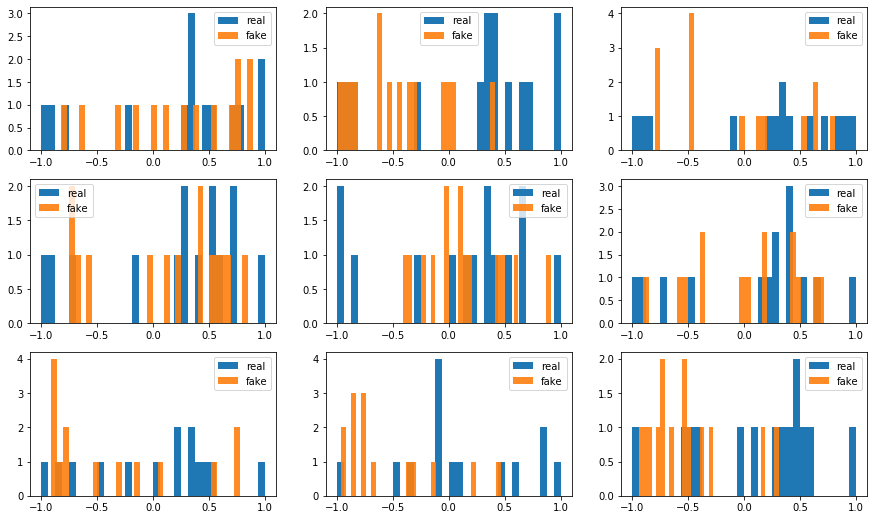

In [186]:
plt.figure(figsize=(15,9))
print("Distribuición original de cada caracteristica vs red Generadora sin entrenar")
for col in range(X_train.shape[1]):
    aux_real = X_train.iloc[:,col]
    aux_fake = data_fake[:,col]
    plt.subplot(3,3,col+1)
    plt.hist(aux_real, bins=32, label="real",)
    plt.hist(aux_fake, bins=32, label="fake", alpha=0.9)
    plt.legend()

In [187]:
def discriminator(input_dim):
    """
    input_dim: dimension de los datos de entrada,
               por ejemplo si es una imagen en escala de gris,
               sería input_dim: (32,32,1)
    """
    model = Sequential()
    model.add(Dense(32, input_shape=input_dim))
    model.add(LeakyReLU(alpha=0.2)) #función rectificadora
    model.add(Dropout(.1))
    model.add(Dense(32))
    model.add(Flatten())
    #activación sigmoid ya que se precisa establecer si es 0 ó 1.
    model.add(Dense(1, activation='sigmoid'))
    return model

In [188]:
D = discriminator((9,))
optimizerD = Adam(lr=0.0001, beta_1=0.5)
#optimizerD = SGD(learning_rate=0.001, momentum=0.1)
D.compile(loss='binary_crossentropy', optimizer=optimizerD, metrics=['accuracy'])

In [189]:
def Gan(generator, discriminator):
    """
    recibe como parámetros de entrada las redes
    generador y discriminador
    """
    model = Sequential()
    model.add(generator)
    discriminator.trainable = False #no se actualizan los pesos
    model.add(discriminator)
    return model

In [190]:
gan = Gan(G,D)
gan.compile(loss='binary_crossentropy', optimizer=optimizerG)
gan.summary()

Model: "sequential_148"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_146 (Sequential)  (None, 9)                 28169     
_________________________________________________________________
sequential_147 (Sequential)  (None, 1)                 1409      
Total params: 29,578
Trainable params: 28,169
Non-trainable params: 1,409
_________________________________________________________________


In [191]:
def get_batches(X_train, batch_size):
    """
    X_train: dataset para o treino
    epochs: quantidade de epocas para o treino do gradiente
    batch: tamanho to batch pra o treino de cada epochs
    """
    batches = []
    num_bat = int(np.ceil(X_train.shape[0]/batch_size))
    lim_i = 0
    lim_s = batch_size
    for i in range(num_bat):
        if lim_s > X_train.shape[0]:
            lim_s = X_train.shape[0]
        batches.append(X_train[lim_i:lim_s])
        lim_i += batch_size
        lim_s += batch_size
    return batches

In [192]:
#treinamento da GAN
def train(X_train, epochs, batch_size, G, D, gan, noise_input):
    g_loss = []
    d_loss = []
    for epoch in range(epochs):
        batches = get_batches(X_train, batch_size)
        count_b = 0
        t_i = time()
        for batch in batches:
            gen_noise = np.random.normal(0, 1, (np.int64(batch.shape[0]), noise_input))
            #gerando as imagens fake
            syntetic_data = G.predict(gen_noise)
            #criação do array de treinamento
            x_combined_batch = np.concatenate((batch, syntetic_data))
            y_combined_batch = np.concatenate((np.ones((batch.shape[0], 1)),
                                               np.zeros((batch.shape[0], 1))))
            #misturar os dados
            #x_combined_batch, y_combined_batch = shuffle(x_combined_batch, y_combined_batch)
            #treino do discriminador
            d_l = D.train_on_batch(x_combined_batch, y_combined_batch)
            # train generator
            noise = np.random.normal(0, 1, (batch.shape[0], noise_input))
            y_mislabled = np.ones((batch.shape[0], 1))
            g_l = gan.train_on_batch(noise, y_mislabled)
 
        t_f = time()
        t = t_f - t_i
        t_i = time()
        d_loss.append(d_l[0])
        g_loss.append(g_l)
        print ('epoch:[%d/%d] [Discriminator::d_loss: %f],[Generator::loss: %f], %f[sec]'
                   % (epoch+1, epochs, d_loss[-1], g_loss[-1], t))
    return g_loss, d_loss

In [193]:
ep = 200
g_loss, d_loss = train(X_train, epochs=ep, batch_size=X_train.shape[0], G=G, D=D, gan=gan, noise_input=100)

epoch:[1/200] [Discriminator::d_loss: 0.664219],[Generator::loss: 0.620794], 13.337519[sec]
epoch:[2/200] [Discriminator::d_loss: 0.664524],[Generator::loss: 0.718684], 0.012782[sec]
epoch:[3/200] [Discriminator::d_loss: 0.688620],[Generator::loss: 0.667538], 0.011066[sec]
epoch:[4/200] [Discriminator::d_loss: 0.664989],[Generator::loss: 0.652053], 0.011271[sec]
epoch:[5/200] [Discriminator::d_loss: 0.685988],[Generator::loss: 0.633936], 0.011168[sec]
epoch:[6/200] [Discriminator::d_loss: 0.688227],[Generator::loss: 0.657894], 0.011341[sec]
epoch:[7/200] [Discriminator::d_loss: 0.696479],[Generator::loss: 0.656476], 0.011341[sec]
epoch:[8/200] [Discriminator::d_loss: 0.665425],[Generator::loss: 0.595940], 0.011218[sec]
epoch:[9/200] [Discriminator::d_loss: 0.673713],[Generator::loss: 0.630924], 0.012262[sec]
epoch:[10/200] [Discriminator::d_loss: 0.674462],[Generator::loss: 0.616578], 0.011684[sec]
epoch:[11/200] [Discriminator::d_loss: 0.692497],[Generator::loss: 0.690250], 0.011665[s

epoch:[103/200] [Discriminator::d_loss: 0.754846],[Generator::loss: 0.548332], 0.014042[sec]
epoch:[104/200] [Discriminator::d_loss: 0.742762],[Generator::loss: 0.540865], 0.016130[sec]
epoch:[105/200] [Discriminator::d_loss: 0.721131],[Generator::loss: 0.608758], 0.012990[sec]
epoch:[106/200] [Discriminator::d_loss: 0.732144],[Generator::loss: 0.591023], 0.012710[sec]
epoch:[107/200] [Discriminator::d_loss: 0.721468],[Generator::loss: 0.552216], 0.012471[sec]
epoch:[108/200] [Discriminator::d_loss: 0.738817],[Generator::loss: 0.582654], 0.011947[sec]
epoch:[109/200] [Discriminator::d_loss: 0.739499],[Generator::loss: 0.577093], 0.011350[sec]
epoch:[110/200] [Discriminator::d_loss: 0.740035],[Generator::loss: 0.591246], 0.011235[sec]
epoch:[111/200] [Discriminator::d_loss: 0.739534],[Generator::loss: 0.557593], 0.011546[sec]
epoch:[112/200] [Discriminator::d_loss: 0.718928],[Generator::loss: 0.597847], 0.011288[sec]
epoch:[113/200] [Discriminator::d_loss: 0.716859],[Generator::loss: 0.

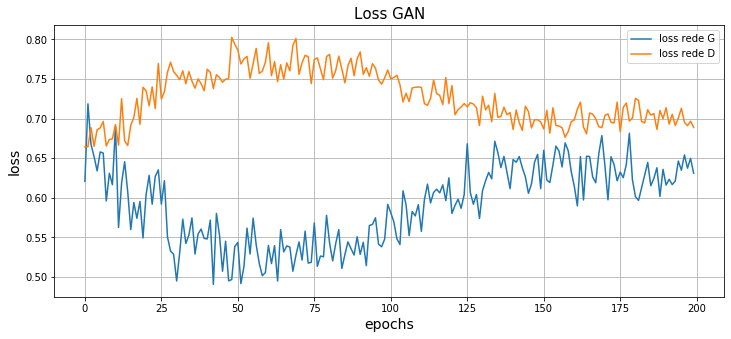

In [194]:
plt.figure(figsize=(12,5))
plt.title("Loss GAN", fontsize=15)
plt.plot(range(ep), g_loss, label="loss rede G")
plt.plot(range(ep), d_loss, label="loss rede D")
plt.xlabel("epochs", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.grid()
plt.legend();

Distribuición original de cada caracteristica vs red Generadora entrenada


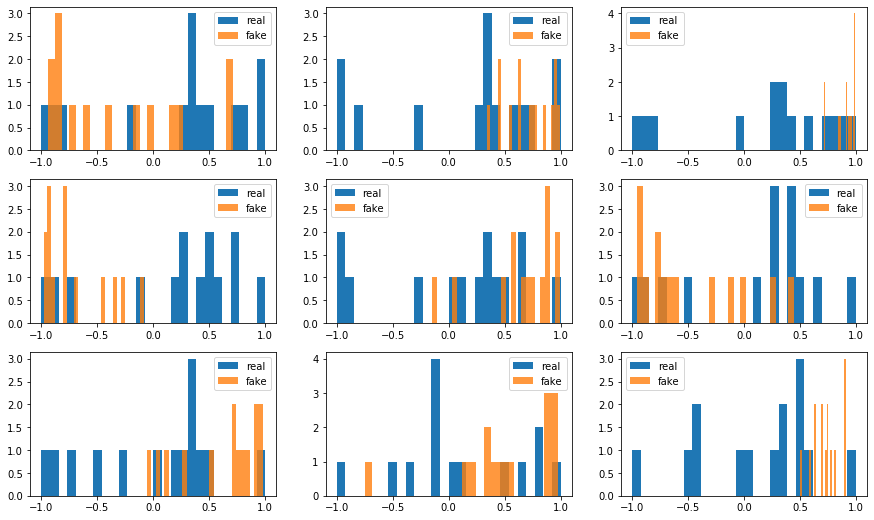

In [195]:
noise = np.random.normal(loc=0, scale=1, size=(X_train.shape[0],100))
data_fake = G.predict(noise)
plt.figure(figsize=(15,9))
print("Distribuición original de cada caracteristica vs red Generadora entrenada")
for col in range(X_train.shape[1]):
    aux_real = X_train.iloc[:,col]
    aux_fake = data_fake[:,col]
    plt.subplot(3,3,col+1)
    plt.hist(aux_real, bins=26, label="real",)
    plt.hist(aux_fake, bins=26, label="fake", alpha=0.8)
    plt.legend()

In [196]:
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_fake_pca = pca.transform(data_fake)
print(X_train_pca.shape, X_fake_pca.shape)

(14, 2) (14, 2)


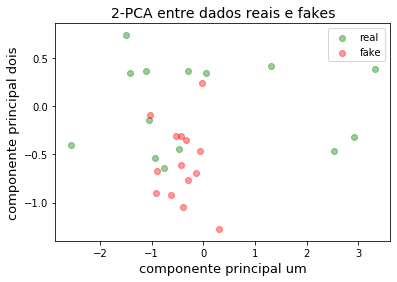

In [197]:
plt.figure(figsize=(6,4))
plt.title("2-PCA entre dados reais e fakes", fontsize=14)
plt.xlabel("componente principal um", fontsize=13)
plt.ylabel("componente principal dois", fontsize=13)
plt.scatter(X_train_pca[:,0], X_train_pca[:,1], color="green", label="real", alpha=0.4)
plt.scatter(X_fake_pca[:500,0], X_fake_pca[:500,1], color="red", label="fake", alpha=0.4)
plt.legend();